In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

warnings.filterwarnings("ignore")
small = True # 작은 데이터셋으로 학습을 테스트하는 용도입니다.

In [6]:
train = pd.read_csv('./data/venti/train.csv')
test = pd.read_csv('./data/venti/test.csv')

print(train.shape, test.shape)

(6036000, 8) (4024000, 7)


## EDA

In [7]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [8]:
# 실습을 위해 데이터 1% 정도로 샘플링합니다.
if small:
  train = train[train['breath_id'] < 1000].reset_index(drop=True)
  train

In [9]:
display(train)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
50795,50796,999,50,50,2.386138,4.941322,1,6.610815
50796,50797,999,50,50,2.417893,4.949937,1,6.962326
50797,50798,999,50,50,2.449599,4.957276,1,7.102930
50798,50799,999,50,50,2.481339,4.963546,1,6.540513


In [10]:
def plot_sample(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]
    r, c  = df_breath[['R', 'C']].values[0]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']
    
    plt.figure(figsize=(12, 4))
    for col in ['u_in', 'u_out', 'pressure']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
        
    plt.legend()
    plt.title(f'breath_id: {sample_id} - R={r}, C={c}')

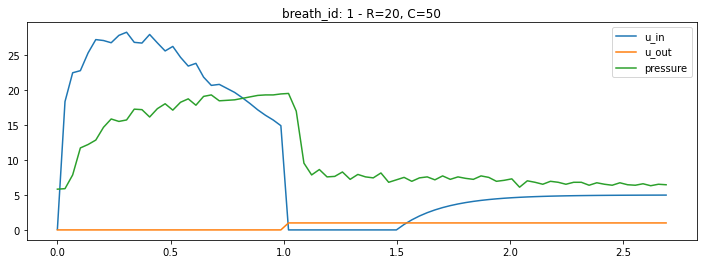

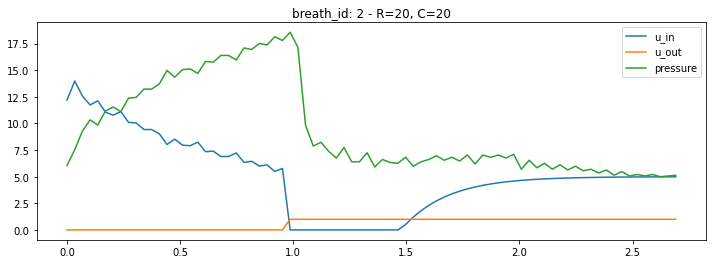

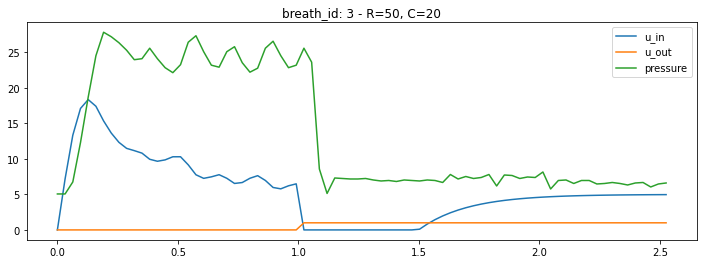

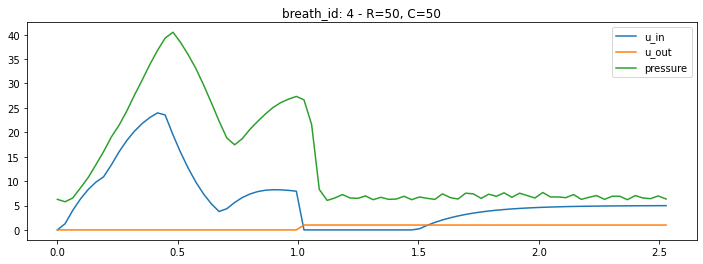

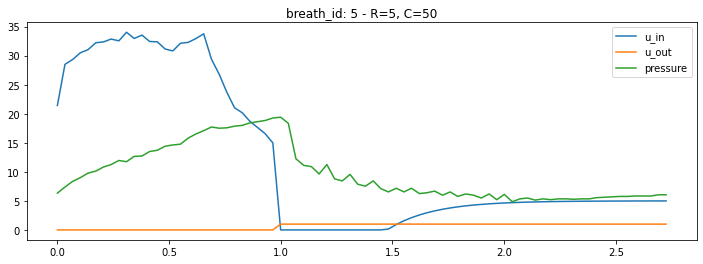

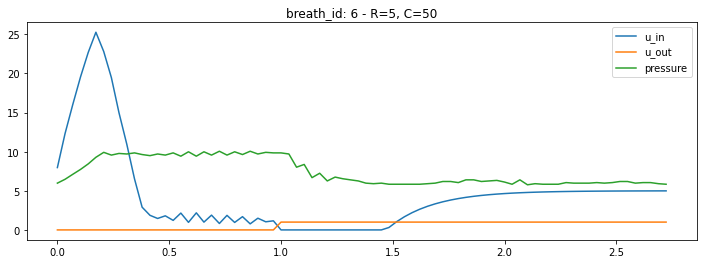

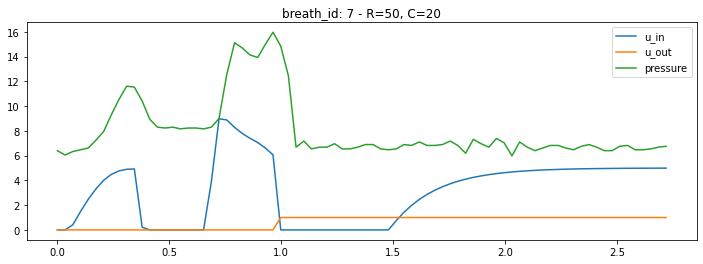

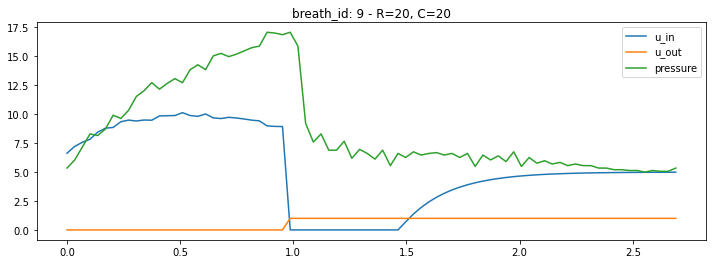

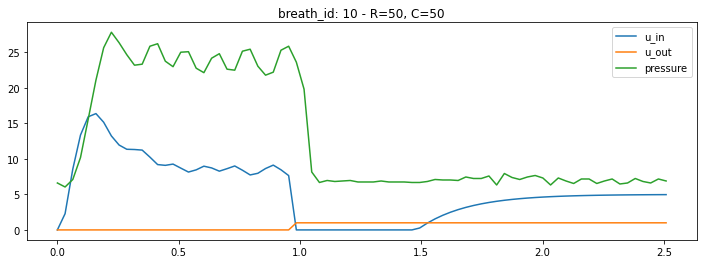

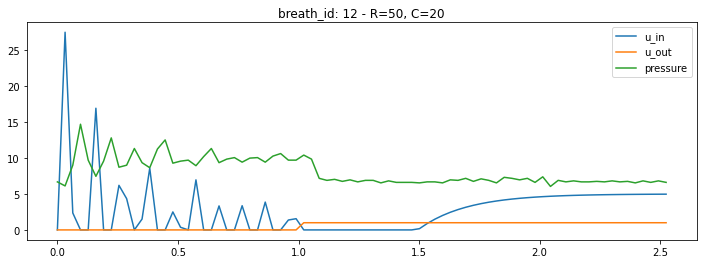

In [11]:
for i in train['breath_id'].unique()[:10]: # 10명만 출력.
    plot_sample(i, train)

## 4. Sequential Modeling

In [12]:
seq_len = 80

y_train = train.pressure.to_numpy().reshape(-1, seq_len)
X_train = train.drop(columns=["pressure", "id", "breath_id"])
test = test.drop(columns=["id", "breath_id"])

In [13]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
test = scaler.transform(test)

# reshaping
X_train = X_train.reshape(-1, seq_len, X_train.shape[-1])
test = test.reshape(-1, seq_len, test.shape[-1])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(508, 80, 5) (127, 80, 5) (508, 80) (127, 80)


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense

In [ ]:
# config variables
epochs = 200
batch_size = 1024
if small:
  epochs = 10
  batch_size = 128


scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

model = Sequential([
                    Input(shape=X_train.shape[1:]), # (80, 5)
                    Bidirectional(LSTM(250, return_sequences=True)),
                    Bidirectional(LSTM(200, return_sequences=True)),
                    Bidirectional(LSTM(150, return_sequences=True)),
                    Bidirectional(LSTM(100, return_sequences=True)),
                    Dense(50, activation='relu'),
                    Dense(1) # output layer
])

model.compile(optimizer='adam', loss='mae')
model.summary()

In [18]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[scheduler],
                    verbose=1)

Epoch 1/10
4/4 [==============================] - 48s 7s/step - loss: 10.3755 - val_loss: 7.1080 - lr: 0.0010
Epoch 2/10
4/4 [==============================] - 25s 7s/step - loss: 5.7263 - val_loss: 5.3858 - lr: 0.0010
Epoch 3/10
4/4 [==============================] - 24s 6s/step - loss: 5.2353 - val_loss: 5.0151 - lr: 0.0010
Epoch 4/10
4/4 [==============================] - 16s 4s/step - loss: 4.9446 - val_loss: 4.7448 - lr: 0.0010
Epoch 5/10
4/4 [==============================] - 26s 7s/step - loss: 4.5526 - val_loss: 4.1504 - lr: 0.0010
Epoch 6/10
4/4 [==============================] - 27s 7s/step - loss: 3.9894 - val_loss: 3.6848 - lr: 0.0010
Epoch 7/10
4/4 [==============================] - 27s 7s/step - loss: 3.5823 - val_loss: 3.7688 - lr: 0.0010
Epoch 8/10
4/4 [==============================] - 28s 7s/step - loss: 3.4865 - val_loss: 3.1913 - lr: 0.0010
Epoch 9/10
4/4 [==============================] - 31s 8s/step - loss: 3.1302 - val_loss: 2.8248 - lr: 0.0010
Epoch 10/10
4/4 [=

In [20]:
preds = model.predict(test).squeeze().reshape(-1, 1).squeeze()
preds

array([8.080124 , 8.84901  , 9.641625 , ..., 6.3342633, 6.29861  ,
       5.779561 ], dtype=float32)

In [22]:
len(preds)

4024000

In [23]:
preds.mean()

10.438393